# AE/VAE on binarised MNIST

 We train an autoencoder and a variational autoencoder a binarised version of MNIST.

# Loading useful stuff

In [ ]:
import sys

%matplotlib inline
import os

import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [ ]:
latent_dims = 2
num_epochs = 100
batch_size = 128
capacity = 64
learning_rate = 1e-3
variational_beta = 1
use_gpu = True

# Loading MNIST and binarising it

In [ ]:
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST

img_transform = transforms.Compose([
    transforms.ToTensor(),
    lambda x: (x>=0.5).float()
])

train_dataset = MNIST(root='./data/MNIST', download=True, train=True, transform=img_transform)
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = MNIST(root='./data/MNIST', download=True, train=False, transform=img_transform)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 107260325.95it/s]


Extracting ./data/MNIST/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 4454336.97it/s]

Extracting ./data/MNIST/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw




100%|██████████| 1648877/1648877 [00:00<00:00, 27631181.84it/s]


Extracting ./data/MNIST/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 19680298.31it/s]

Extracting ./data/MNIST/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/MNIST/raw



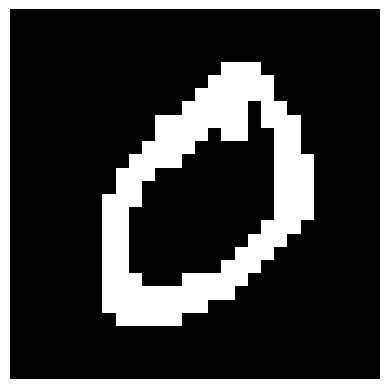

In [ ]:
plt.imshow(train_dataset[1][0][0], cmap='gray')
plt.axis('off')
plt.show()

## Regular Auto-Encoder

Let us start with a regular auto-encoder. We want to encode (or compress) the data into a low-dimensional embedding.


*   The low-dimensional subspace $\mathbb{R}^d$ is the **code space**.

*   The decoder is a function $$\text{Decoder}_{\theta_{decoder}} : \mathbb{R}^d \longrightarrow [0,1]^{28 \times 28}$$ that will transform low-dimensional codes into distributions over images.

*   Conversely, the encoder is a function $$\text{Encoder}_{\theta_{encoder}} : \{0,1\}^{28 \times 28} \longrightarrow \mathbb{R}^d$$ that will encode the images in low-dimensional space.

* Both functions are parametrised by (deep) neural nets whose weigths are stored in $\theta_{decoder}$ and $\theta_{encoder}$.












 The loss function is the **average reconstruction error**:

$$\ell_{AE}(\theta_{encoder},\theta_{decoder}) = \sum_{i=1}^n \text{Xentropy}(x_i,\text{Decoder}_{\theta_{decoder}}(\text{Encoder}_{\theta_{encoder}}(x_i)).$$

Indeed, we want to be able to **reconstruct (approximately) the original data using only the low-dimensional embeddings**.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1)
        x = self.fc(x)
        return x

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

In [ ]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent = self.encoder(x)
        x_recon = self.decoder(latent)
        return x_recon

In [ ]:
ae = Autoencoder()
criterion = nn.BCELoss()

device = torch.device("cuda:0" if use_gpu and torch.cuda.is_available() else "cpu")
ae = ae.to(device)

num_params = sum(p.numel() for p in ae.parameters() if p.requires_grad)
print('Number of parameters: %d' % num_params)

Number of parameters: 295811


In [ ]:
optimizer = torch.optim.Adam(params=ae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
# set to training mode
ae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(30):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.to(device)

        # vae reconstruction
        image_batch_recon = ae(image_batch)

        # reconstruction error
        loss = criterion(image_batch_recon, image_batch)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 30] average reconstruction error: 0.233885
Epoch [2 / 30] average reconstruction error: 0.203491
Epoch [3 / 30] average reconstruction error: 0.197586
Epoch [4 / 30] average reconstruction error: 0.193671
Epoch [5 / 30] average reconstruction error: 0.190706
Epoch [6 / 30] average reconstruction error: 0.188671
Epoch [7 / 30] average reconstruction error: 0.187421
Epoch [8 / 30] average reconstruction error: 0.186395
Epoch [9 / 30] average reconstruction error: 0.185573
Epoch [10 / 30] average reconstruction error: 0.184902
Epoch [11 / 30] average reconstruction error: 0.184482
Epoch [12 / 30] average reconstruction error: 0.183908
Epoch [13 / 30] average reconstruction error: 0.183559
Epoch [14 / 30] average reconstruction error: 0.183127
Epoch [15 / 30] average reconstruction error: 0.182924
Epoch [16 / 30] average reconstruction error: 0.182459
Epoch [17 / 30] average reconstruction error: 0.182198
Epoch [18 / 30] average reconstruction error: 0.182040
Epoch 

Let's look at the faitfulness of the reconstructions:

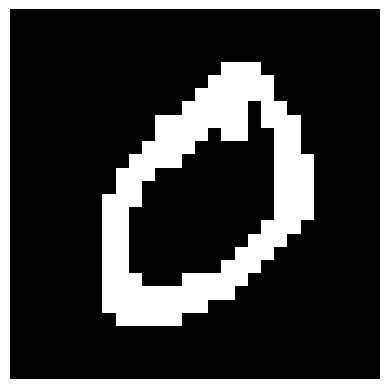

In [ ]:
plt.imshow(train_dataset[1][0][0].numpy(), cmap='gray')
plt.axis('off')
plt.show()

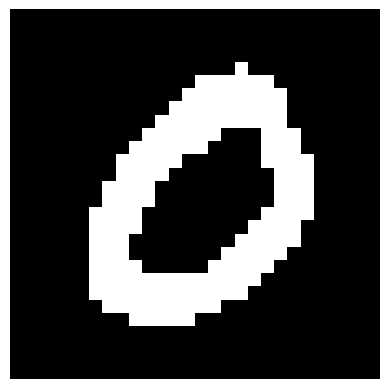

In [ ]:
plt.imshow((ae(train_dataset[1][0].unsqueeze(0).cuda())>0.5).detach().cpu().numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

1.  The mathematical formulas for the encoder and decoder defined via Keras
 $$\text{Decoder}_{\theta_{decoder}} : \mathbb{R}^d \longrightarrow [0,1]^{28 \times 28}$$

$$\text{Decoder}_{\theta_{decoder}} : \mathbf{x} \mapsto \sigma (W_2 \text{ReLU}(W_1\text{ReLU}(W_0x + b_0) + b_1 ) + b_2). $$

2. The decoder output continuous images! It can't be changed easily because it would not be differentiable. We can't train a binary decoder because of this, but we can use thresholding after training to obtain binary images.

3. We plot the low-dimensional representation

In [ ]:
train_images = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

low_dim_rep = ae.encoder(train_images.cuda()).detach().cpu().numpy()

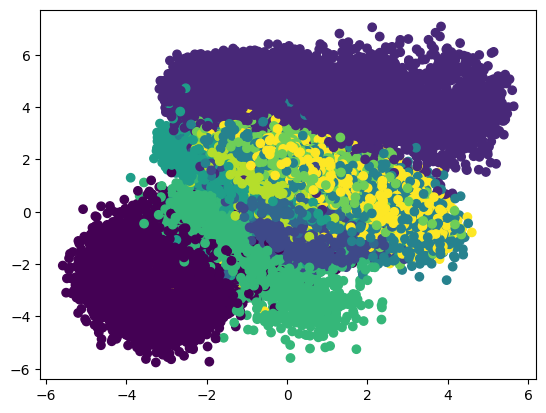

In [ ]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

plt.scatter(low_dim_rep[:,0],low_dim_rep[:,1], c = train_labels)
plt.show()

**This simple auto-encoder is not a probabilistic model! A VAE is a probabilistic version of it that allows to also sample new "fake" images (among many other applications).**

# VAE: defining a deep latent variable model and its inference network

We will use a **deep latent variable model with a Gaussian prior and a Bernoulli observation model**. This can be written:

$$p_{\boldsymbol{\theta}}(\mathbf{x}_1,...,\mathbf{x}_n) = \prod_{i=1}^n p(\mathbf{x}_i|\mathbf{z}_i)p(\mathbf{z}_i),$$
$$p(\mathbf{z}_i) = \mathcal{N}(\mathbf{z}_i|\mathbf{0}_d,\mathbf{I}_d), $$
$$p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z}_i) = \prod_{j =1}^{28 \times 28} \mathcal{B} (x_{ij}|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i)),$$

where $\boldsymbol{\pi}_{\boldsymbol{\theta}}: \mathbb{R}^d \rightarrow [0,1]^p$ is a function (called the **decoder**) parametrised by a deep neural net.

In [ ]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        c = capacity
        self.fc = nn.Linear(in_features=latent_dims, out_features=c*2*7*7)
        self.conv2 = nn.ConvTranspose2d(in_channels=c*2, out_channels=c, kernel_size=4, stride=2, padding=1)
        self.conv1 = nn.ConvTranspose2d(in_channels=c, out_channels=1, kernel_size=4, stride=2, padding=1)

    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), capacity*2, 7, 7) # unflatten batch of feature vectors to a batch of multi-channel feature maps
        x = F.relu(self.conv2(x))
        x = torch.sigmoid(self.conv1(x)) # last layer before output is sigmoid, since we are using BCE as reconstruction loss
        return x

To be able to train our model, we will need an **encoder** (aka **inference network**), that will allow us to approximate the intractable posterior $p(\mathbf{z}|\mathbf{x})$.
The approximate posterior is defined as follows
$$ q(\mathbf{z}|\mathbf{x}) = \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} )),
$$
where $\mathbf{x} \mapsto (\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x} ), \mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x} ))$ is a function from the data space (i.e. $\{0,1\}^p$) to $\mathbb{R}^d \times [0, \infty[^d$ parametrised by a deep neural network. In other words, the encoder outputs the mean and the diagonal of the covariance matrix of the approximate posterior $q(\mathbf{z}|\mathbf{x})$.

In [ ]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        c = capacity
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=c, kernel_size=4, stride=2, padding=1) # out: c x 14 x 14
        self.conv2 = nn.Conv2d(in_channels=c, out_channels=c*2, kernel_size=4, stride=2, padding=1) # out: c x 7 x 7
        self.fc_mu = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)
        self.fc_logvar = nn.Linear(in_features=c*2*7*7, out_features=latent_dims)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(x.size(0), -1) # flatten batch of multi-channel feature maps to a batch of feature vectors
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

In [ ]:
class VariationalAutoencoder(nn.Module):
    def __init__(self):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()

    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar

    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu

# Sampling from the deep generative model

Before we train it, let's look at some samples from the model.

In [ ]:
vae = VariationalAutoencoder().cuda()
latent = vae.latent_sample(torch.zeros(size=(1,2)),torch.zeros(size=(1,2)))
sample = vae.decoder(latent.cuda())

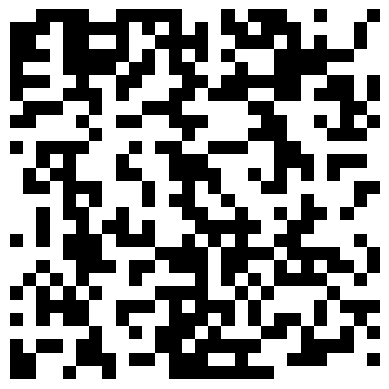

In [ ]:
plt.imshow(torch.bernoulli(sample.detach()).cpu().numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

In [ ]:
train_images = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

low_dim_rep = vae.encoder(train_images.cuda())[0].detach().cpu().numpy()

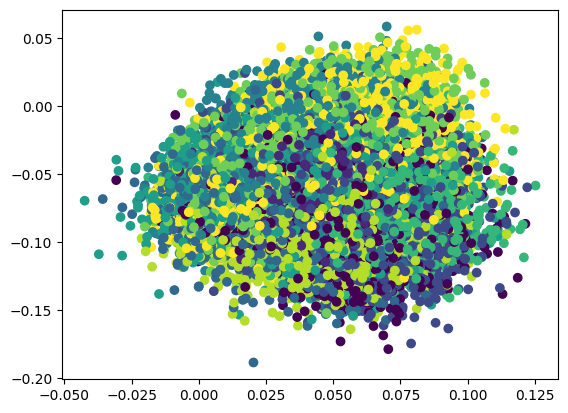

In [ ]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

plt.scatter(low_dim_rep[:,0],low_dim_rep[:,1], c = train_labels)
plt.show()

They look really bad... But we haven't started training yet!

# Training a VAE

The **VAE objective** is defined as
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \left[ \log\frac{p_{\boldsymbol{\theta}}(\mathbf{x}_i|\mathbf{z})p(\mathbf{z})}{q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)} \right].
$$

It is a lower bound of the likelihood of the deep latent variable model. Rather than the intractable likelihood, we'll **maximise this bound**.

To see more clearly the neural nets inside the objective, we may rewrite it as:
$$
\mathcal{L}_1 (\boldsymbol{\theta,\gamma}) = \sum_{i=1}^n \mathbb{E}_{\mathbf{z} \sim \mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \left[ \log\frac{\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}))\mathcal{N}(\mathbf{z}|\mathbf{0}_d,\mathbf{I}_d)}{\mathcal{N}(\mathbf{z} | \mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))} \right].
$$

We can follow these steps to create a TF function that computes an unbiased estimate of it (using a single sample from the approximate posterior), for all $\mathbf{x}_i$ in our batch:


*   Encode the batch fo data points, to get the $\mathbf{m}_\boldsymbol{\gamma} ( \mathbf{x}_i ), \text{Diag}(\mathbf{s}_\boldsymbol{\gamma} ( \mathbf{x}_i ))$
*   Use these encoder outputs to define $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$ as a TF probability distribution
*   Take one sample $\mathbf{z}_i$ from $q_{\boldsymbol{\gamma}}(\mathbf{z}|\mathbf{x}_i)$, and use it to:
  *   Compute $\mathcal{B} (\mathbf{x}_i|\boldsymbol{\pi}_{\boldsymbol{\theta}}(\mathbf{z}_i))$ by decoding $\mathbf{z}_i$
  *   Compute the rest of the log of $p(\mathbf{z}_i)$ and $q_{\boldsymbol{\gamma}}(\mathbf{z}_i|\mathbf{x}_i)$ using the $\texttt{.logprob}$ method from TF probability.






In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # recon_x is the probability of a multivariate Bernoulli distribution p.
    # -log(p(x)) is then the pixel-wise binary cross-entropy.
    # Averaging or not averaging the binary cross-entropy over all pixels here
    # is a subtle detail with big effect on training, since it changes the weight
    # we need to pick for the other loss term by several orders of magnitude.
    # Not averaging is the direct implementation of the negative log likelihood,
    # but averaging makes the weight of the other loss term independent of the image resolution.
    recon_loss = F.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='sum')

    # KL-divergence between the prior distribution over latent vectors
    # (the one we are going to sample from when generating new images)
    # and the distribution estimated by the generator for the given image.
    kldivergence = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return recon_loss + variational_beta * kldivergence



In [ ]:
optimizer = torch.optim.Adam(params=vae.parameters(), lr=learning_rate, weight_decay=1e-5)

In [ ]:
# set to training mode
vae.train()

train_loss_avg = []

print('Training ...')
for epoch in range(num_epochs):
    train_loss_avg.append(0)
    num_batches = 0

    for image_batch, _ in train_dataloader:

        image_batch = image_batch.cuda()

        # vae reconstruction
        image_batch_recon, latent_mu, latent_logvar = vae(image_batch)

        # reconstruction error
        loss = vae_loss(image_batch_recon, image_batch, latent_mu, latent_logvar)

        # backpropagation
        optimizer.zero_grad()
        loss.backward()

        # one step of the optmizer (using the gradients from backpropagation)
        optimizer.step()

        train_loss_avg[-1] += loss.item()
        num_batches += 1

    train_loss_avg[-1] /= num_batches
    print('Epoch [%d / %d] average reconstruction error: %f' % (epoch+1, num_epochs, train_loss_avg[-1]))

Training ...
Epoch [1 / 100] average reconstruction error: 23264.720657
Epoch [2 / 100] average reconstruction error: 21132.835933
Epoch [3 / 100] average reconstruction error: 20543.730656
Epoch [4 / 100] average reconstruction error: 20103.832464
Epoch [5 / 100] average reconstruction error: 19837.543210
Epoch [6 / 100] average reconstruction error: 19632.521409
Epoch [7 / 100] average reconstruction error: 19473.708984
Epoch [8 / 100] average reconstruction error: 19355.346736
Epoch [9 / 100] average reconstruction error: 19252.480340
Epoch [10 / 100] average reconstruction error: 19145.971994
Epoch [11 / 100] average reconstruction error: 19056.259941
Epoch [12 / 100] average reconstruction error: 18975.204818
Epoch [13 / 100] average reconstruction error: 18915.209530
Epoch [14 / 100] average reconstruction error: 18859.321204
Epoch [15 / 100] average reconstruction error: 18804.520052
Epoch [16 / 100] average reconstruction error: 18762.786191
Epoch [17 / 100] average reconstruct

In [ ]:
latent = vae.latent_sample(torch.zeros(size=(1,2)),torch.zeros(size=(1,2)))
sample = vae.decoder(latent.cuda())

Let's now look at the samples, they're not super impressive but they're not too bad! We can think of ways to improve the model.

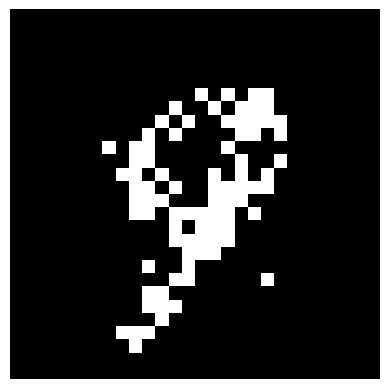

In [ ]:
plt.imshow(torch.bernoulli(sample.detach()).cpu().numpy().reshape((28,28)), cmap='gray')
plt.axis('off')
plt.show()

We can also look at the low-dimensional representation by plotting, for all $i$, $\mathbb{E}_{\mathbf{z} \sim q_\gamma(\mathbf{z} | \mathbf{x}_i)}[\mathbf{z}] = \mathbf{m}_\gamma(\mathbf{x}_i)$.

In [ ]:
train_images = torch.stack([train_dataset[i][0] for i in range(len(train_dataset))])

low_dim_rep = vae.encoder(train_images.cuda())[0].detach().cpu().numpy()

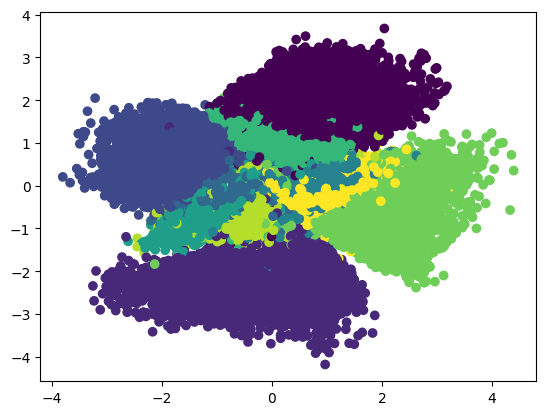

In [ ]:
train_labels = [train_dataset[i][1] for i in range(len(train_dataset))]

plt.scatter(low_dim_rep[:,0],low_dim_rep[:,1], c = train_labels)
plt.show()